In [1]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as T
import torch.optim as optim
import torch.nn as nn
import cv2
import json
import matplotlib.pyplot as plt

In [2]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cpu


In [3]:
np.random.seed(3)

def show_mask(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()

In [4]:
# -----------------------------
# Custom Dataset for River Segmentation
# -----------------------------
class RiverSegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        """
        Args:
            images_dir (str): Path to directory with images.
            masks_dir (str): Path to directory with mask .npy files.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        # List image files (adjust extensions as needed)
        self.image_files = [f for f in os.listdir(images_dir) if f.endswith(('.jpg', '.png'))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_filename = self.image_files[idx]
        img_path = os.path.join(self.images_dir, img_filename)
        # Assumes mask file has the same basename with .npy extension
        mask_filename = os.path.splitext(img_filename)[0] + '.pn.npy'
        mask_path = os.path.join(self.masks_dir, mask_filename)

        # Load image and mask
        image = cv2.imread(img_path)
        if self.transform:
            image = self.transform(image)
        mask = np.load(mask_path)  # Assume mask is a 2D numpy array of labels
        # Convert mask to tensor (long type for CrossEntropyLoss)
        mask = torch.from_numpy(mask).long()
        return image, mask

In [5]:
# -----------------------------
# Define Transforms, Dataset, and DataLoader
# -----------------------------
transform = T.Compose([
    T.ToTensor() #,
    # Normalize with ImageNet statistics or adjust if needed
    # T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [6]:
# Replace these with your actual paths
images_dir = '/Users/cameronswapp/Documents/STAT5810_ML/ml_intro/initial_images'
masks_dir = 'initial_masks'

dataset = RiverSegmentationDataset(images_dir, masks_dir)#, transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=0)

In [7]:
# Read an image to predict the mask using the SAM2 model
data = [os.path.join(images_dir, f) for f in os.listdir(images_dir) if f.endswith(('.json'))]

def read_batch(data, index):
    with open(data[index], 'r') as f:
        json_obj = json.load(f)


    image = cv2.imread(json_obj['image'])
    mask = torch.tensor(np.load(json_obj['map']))
    return image, mask

img, mask = read_batch(data, 0)

In [8]:
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

sam2_checkpoint = "../checkpoints/sam2.1_hiera_tiny.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_t.yaml"

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)

predictor = SAM2ImagePredictor(sam2_model)

predictor.model.sam_mask_decoder.train(True) # enable training of mask decoder 
predictor.model.sam_prompt_encoder.train(True) # enable training of prompt encoder

PromptEncoder(
  (pe_layer): PositionEmbeddingRandom()
  (point_embeddings): ModuleList(
    (0-3): 4 x Embedding(1, 256)
  )
  (not_a_point_embed): Embedding(1, 256)
  (mask_downscaling): Sequential(
    (0): Conv2d(1, 4, kernel_size=(2, 2), stride=(2, 2))
    (1): LayerNorm2d()
    (2): GELU(approximate='none')
    (3): Conv2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
    (4): LayerNorm2d()
    (5): GELU(approximate='none')
    (6): Conv2d(16, 256, kernel_size=(1, 1), stride=(1, 1))
  )
  (no_mask_embed): Embedding(1, 256)
)

In [9]:
# -----------------------------
# Optimizer and Loss
# -----------------------------
optimizer = optim.Adam(sam2_model.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()  # Expects logits [B, C, H, W] and target [B, H, W]

In [10]:
input_point = np.empty((0, 2))    # Correct shape for zero points
input_label = np.empty((0,), dtype=int)  # Correct shape for zero labels

predictor.set_image(img)
pred_masks, scores, logits = predictor.predict(
    point_coords = input_point,
    point_labels = input_label,
    multimask_output = False
)

pred_masks = torch.tensor(pred_masks)

In [11]:
loss = loss_fn(pred_masks, mask)
print(loss)

tensor(5448.6201)


In [ ]:
input_point = np.empty((0, 2))    # Correct shape for zero points
input_label = np.empty((0,), dtype=int)  # Correct shape for zero labels

num_epochs = 10
for epoch in range(num_epochs):
    sam2_model.train()
    for i in range(len(data)):
        img, mask = read_batch(data, i)

        # img, mask = img.to(device), mask.to(device).float()

        optimizer.zero_grad()
        predictor.set_image(img)
        pred_masks, scores, logits = predictor.predict(
            point_coords=input_point,
            point_labels=input_label,
            multimask_output=False
        )

        # Ensure pred_masks is a PyTorch tensor with grad
        # This line causes an error when trying to use loss.backward()
        # pred_masks = torch.tensor(pred_masks, dtype=torch.float, device=device)  # Ensure grad tracking

        # This allows us to use loss.backward() but the loss is not being minimized
        pred_masks = torch.from_numpy(pred_masks).float().to(device).requires_grad_(True)


        loss = loss_fn(pred_masks, mask)
        loss.backward()
        optimizer.step()

        if i % 10 == 0:
            print(f"Epoch {epoch}, Iteration {i}, Loss: {loss.item()}")


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

AttributeError: 'Tensor' object has no attribute 'astype'

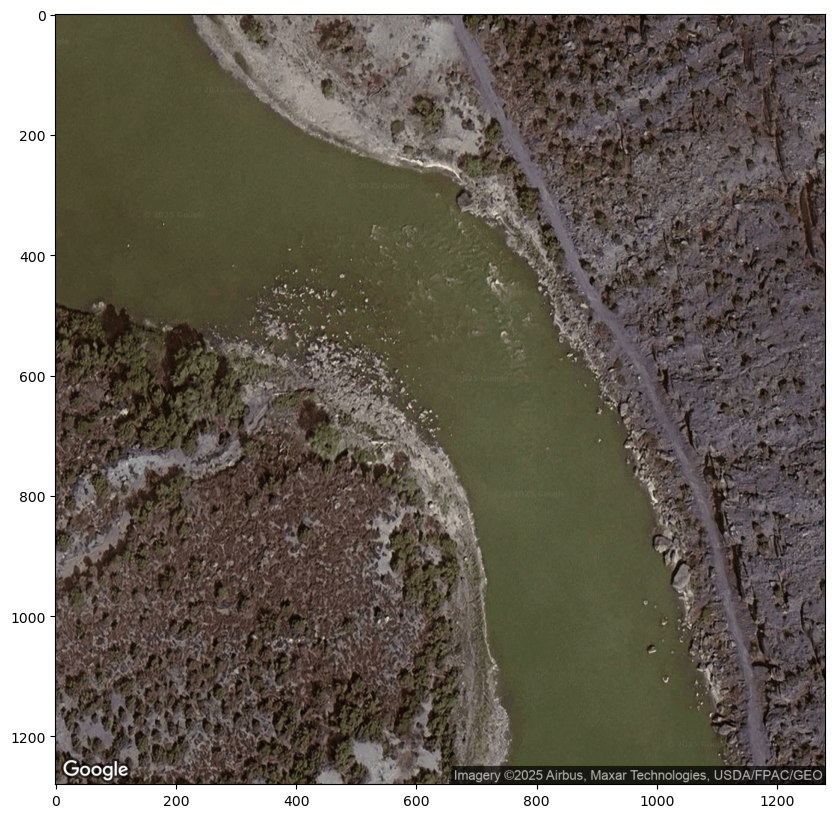

In [15]:
show_masks(img, pred_masks, scores, borders=True)

In [ ]:
torch.save(sam2_model.state_dict(), f"sam2_model_finetuned_epoch_{epoch + 1}.pt")

In [8]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)
sorted_ind = np.argsort(scores)[::-1]
masks = masks[sorted_ind]
scores = scores[sorted_ind]
logits = logits[sorted_ind]

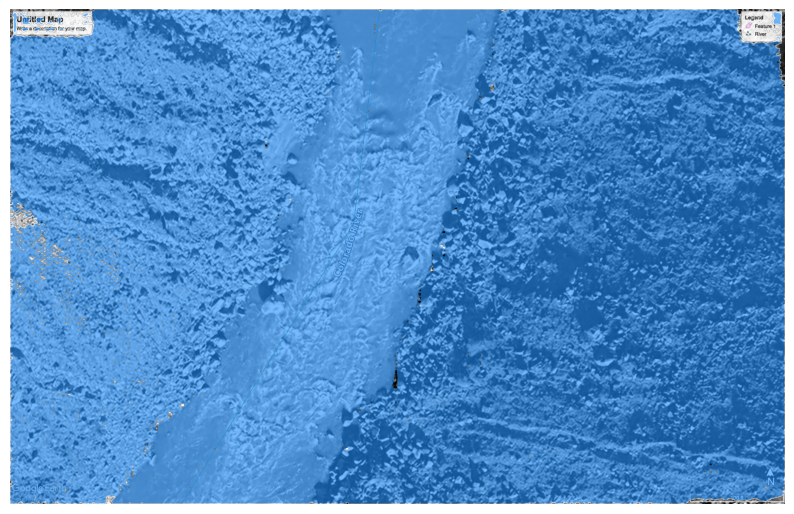

In [9]:
input_point = np.empty((0, 2))    # Correct shape for zero points
input_label = np.empty((0,), dtype=int)  # Correct shape for zero labels

mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask

masks, scores, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)

show_masks(image, masks, scores, point_coords=input_point, input_labels=input_label)